In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [56]:
# Data Generation

n, d = 100, 30

max_eq = 1

L_max = 20
L = np.ones(n)
L[0:max_eq] = L_max

mu = .1 * np.ones(n)

# Generate A

A = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    A.append(Q @ np.diag(evalues) @ Q.T)

# Generate C

C = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    C.append(Q @ np.diag(evalues) @ Q.T)

# Generate B

mu = np.zeros(n)
B = []
for k in range(n):
    evalues = np.random.uniform(mu[k], L[k], d)
    if k < max_eq:
        evalues[0] = L_max
    elif k == (n - 1):
        evalues[0] = mu[k]
    rndm_mx = np.random.normal(0, 1, (d, d))
    _, Q = np.linalg.eig(rndm_mx.T @ rndm_mx)
    
    B.append(Q @ np.diag(evalues) @ Q.T)

# Generate a and c from Normal(0,1)
a = []
c = []
for k in range(n):
    a.append(np.random.normal(0,1,d))
    c.append(np.random.normal(0,1,d))
    
data = (A, B, C, a, c)

# Store A,B,C in a Block Matrix and computation of Lipchitz Constants
M = []
z = []
L_M = []
for k in range(n):
    M.append(np.block([[data[0][k], data[1][k]], [-data[1][k].T, data[2][k]]]))
    z.append(np.concatenate((data[3][k], data[4][k])))
    eigenvalues, _ = np.linalg.eig(M[k].T @ M[k])
    L_M.append(np.sqrt(max(eigenvalues)))

M_mean = np.mean(M, axis = 0)
eigen, _ = np.linalg.eig(M_mean.T @ M_mean)
L_total = np.sqrt(np.max(eigen))

# Computation of \mu
muA_list = list(map(lambda X: np.min(np.linalg.eig(X)[0]), A))
muB_list = list(map(lambda X: np.min(np.linalg.eig(X)[0]), B))
mu_list = list(map(lambda x,y: min(x,y), muA_list, muB_list))

A_total = np.mean(A, axis = 0)
mu_A = np.min(np.linalg.eig(A_total)[0])
B_total = np.mean(B, axis = 0)
mu_B = np.min(np.linalg.eig(B_total)[0])
mu_total = min(mu_A, mu_B)

# Store the Data to use for Operator F
dat = (M,z)

# Compute the Optimal point
x_optimal = - np.linalg.inv(M_mean) @ np.mean(z, axis = 0)

# Uniform Sampling parameters
p_uniform = np.ones(n)/n
delta_uniform = 2 * np.mean(np.array(L_M)**2)

# Compute Variance
var = []
for k in range(n):
    var.append(np.linalg.norm(M[k] @ x_optimal + z[k]))


# Important Sampling
epsilon = 1e-8
sigma_opt = np.mean(var)**2
#alpha = np.mean(L_M)/(np.mean(L_M) + ((2 * sigma_opt)/ (mu_total * epsilon)))
alpha = 1
p_important = alpha * (L_M/ np.sum(L_M))+ (1 - alpha) * (var/np.sum(var))
delta_important = (2/(n**2))*np.sum(np.array(L_M)**2/p_important)
#p_important = alpha * (L/ np.sum(L))+ (1 - alpha)/n
#delta_important = (2/(n**2))*np.sum(np.array(L)**2/p_important)


In [57]:
def operator_F(x, data, sample):
    result = 0
    for i in sample:
        result += data[0][i] @ x + data[1][i]
    return result/len(sample)

def SPEG_constant(x_0, x_optimal, L, mu, delta, batchsize, n, data, operator, prob, iterations = 1000, trials = 10):
    relative_error = []
    total_trajectory = []
    
    initial_error = np.sum((x_0 - x_optimal)**2)
    omega_hat = min(1/(4 * L), mu/(18 * delta))
    
    for trial in range(trials):
        error = []
        trajectory = []
        
        sample = np.random.choice(n, batchsize, p = prob)
        op = operator(x_0, data, sample)
        x = x_0 - omega_hat * op
        
        for iteration in range(iterations):
            x_mid = x - omega_hat * op
            sample = np.random.choice(n, batchsize, p = prob)
            op = operator(x_mid, data, sample)
            x = x - omega_hat * op
            
            trajectory.append(x)
            error.append(np.sum((x - x_optimal)**2)/initial_error)
            
        relative_error.append(error)
        total_trajectory.append(trajectory)
        
        return np.mean(relative_error, axis = 0), np.mean(total_trajectory, axis = 0)

In [58]:
no_iterations = 1000

IS_err, IS_trajectory = SPEG_constant(np.ones(2*d), x_optimal, L_total, mu_total, delta_important, 1, n, (M,z), operator_F, p_important, iterations= no_iterations)
US_err, US_trajectory = SPEG_constant(np.ones(2*d), x_optimal, L_total, mu_total, delta_uniform, 1, n, (M,z), operator_F, p_uniform, iterations= no_iterations)

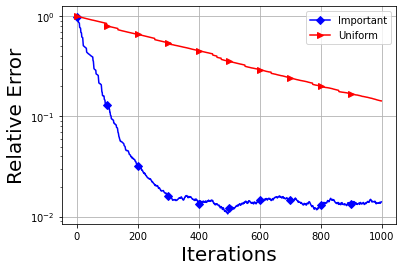

In [59]:
plt.figure()
markers_on = np.arange(0, no_iterations, no_iterations/10).astype(int)
plt.plot(np.arange(len(IS_err)), IS_err, '-bD', markevery = markers_on, label = 'Important')
plt.plot(np.arange(len(US_err)), US_err, '-r>', markevery = markers_on, label = 'Uniform')
plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 20)
plt.xlabel("Iterations", fontsize = 20)
plt.legend()
#plt.title("Sampling")
plt.savefig(f"Uniform vs Important Sampling with Lmax = {L_max} .pdf", format="pdf", bbox_inches="tight")